In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
from sklearn.utils import resample
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering, KMeans
from functools import partial
from scipy.spatial import distance
import umap
from sklearn.mixture import GaussianMixture
from sklearn.metrics import calinski_harabasz_score
from scipy.spatial.distance import pdist
from sklearn.preprocessing import Normalizer
from numpy.fft import fft
import math
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [8]:
X_train=pd.read_csv('..//eda//X_val.csv')

In [9]:
X_train.head()

,time,seconds_elapsed_orientation,qz_orientation,qy_orientation,qx_orientation,qw_orientation,roll_orientation,pitch_orientation,yaw_orientation,seconds_elapsed_location,...,horizontalAccuracy_location_network,speed_location_network,bearing_location_network,altitude_location_network,longitude_location_network,latitude_location_network,seconds_elapsed_gravity,z_gravity,y_gravity,x_gravity
0,1694888248862995700,168.807996,0.471321,-0.713613,-0.387236,0.344473,-2.763092,1.221069,0.727890,168.334362,...,20.083000,0.0,0.0,88.599998,3.144070,50.685068,168.807996,-3.119213,-9.214948,1.235167
1,1697612174876508700,288.830509,-0.364199,0.765647,-0.497252,0.184076,-3.021737,0.834202,-1.205141,288.238000,...,800.000000,0.0,0.0,0.000000,3.102946,50.684728,288.830509,-6.543922,-7.260772,0.792879
2,1697620173538661400,236.055661,0.322516,-0.324366,0.887429,0.056911,-2.481816,0.108431,-2.477898,235.810000,...,21.989000,0.0,0.0,69.099998,3.095562,50.688133,236.055661,-7.702148,-1.062021,5.976573
3,1694728325837354200,5.838354,-0.557139,0.430002,-0.629847,0.328614,-1.942081,1.104178,-2.740828,5.413000,...,30.473000,0.0,0.0,89.900002,3.139939,50.684294,5.838354,-1.559871,-8.758158,4.126968
4,1694728507523409200,187.524409,-0.039950,-0.029223,-0.798352,0.600153,-2.798132,1.272818,2.813472,187.184364,...,17.563999,0.0,0.0,84.300003,3.137738,50.682879,187.524409,-2.714808,-9.373393,0.969407


In [10]:
#  We identified outliers in the following columns during Exploratory Data Analysis (EDA):
#  ['speedAccuracy_location', 'vertical_accuracy_location_network', 'horizontalAccuracy_location',
#  'verticalAccuracy_location', 'speed_location', 'speedAccuracy_location_gps', 'verticalAccuracy_location_gps',
#  'horizontalAccuracy_location_gps', 'atitude_location_gps', 'verticalAccuracy_location_network',
#  'horizontalAccuracy_location_network', 'atitude_location_network'].
#  We'll replace these outliers with the 0.95 quantille value for each respective column.

class OutlierHandlerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.percentiles = {}

    def fit(self, X, y=None):
        for column in self.columns:
            self.percentiles[column] = np.percentile(X[column], [0.05, 99.95])
        return self

    def transform(self, X):
        X_copy = X.copy()
        for column in self.columns:
            lower_bound, upper_bound = self.percentiles[column]
            X_copy[column] = np.where(X_copy[column] < lower_bound, 
                                      lower_bound, 
                                      np.where(X_copy[column] > upper_bound, 
                                               upper_bound, 
                                               X_copy[column]))
        return X_copy

In [11]:
# Since it was observed through exploratory data analysis (EDA) that columns related to elapsed time are similar, 
# we want to consolidate them by calculating their mean value. This transformer computes the average of the elapsed time
# values and removes the individual columns to avoid redundant information.

class AverageSecondsElapsedTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, keyword='seconds_elapsed_'):
        self.keyword = keyword
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        columns_to_average = X.filter(like=self.keyword).columns
        X['seconds_elapsed_time'] = X[columns_to_average].mean(axis=1)
        X = X.drop(columns=columns_to_average)
        return X

In [12]:
len(X_train['seconds_elapsed_pedometer'].loc[X_train['seconds_elapsed_pedometer']<0])/len(X_train)

0.19835260434538773

In [13]:
# We have decided to drop the seconds_elapsed_time_pedometer column from our dataset. This decision is based on 
# the fact that 20% of its values are negative, and we are uncertain about the cause (possibly a device issue or a time shift). 
# Since we have other columns capturing elapsed time, we can safely remove this problematic column.

# Additionally, we will use a transformer to drop columns that contain only a single unique value, as they do not 
# provide any useful information for our model. We will also drop the original time column after extracting relevant time features from it.

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.columns is not None:
            X = X.drop(columns=self.columns, errors='ignore')
        return X

In [14]:
# Since we already have roll, pitch and yaw orientation values
# we do not need to convert quaterions (qx, qy, qz, qw) to Euler angles.

In [15]:
# Adding time features to capture the hour and minute of the day, which may be relevant for detecting patterns
# in the data. Since we are extracting time features, we will drop the original time column, which serves a role
# in our dataset similar to primary key.

class TimeFeatureExtraction(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['time'] = pd.to_datetime(X['time'], unit='ns')
        X['hour'] = X['time'].dt.hour
        X['minute'] = X['time'].dt.minute
        return X

In [16]:
# Based on our exploratory data analysis (EDA), we have identified that there are columns containing speed values. 
# We can reasonably assume that these speed-related columns will be among the most important features for our clasterization activity model.

X_train['speed_location_gps'].corr(X_train['speed_location'])

0.9807427349737718

In [17]:
# xGPS data tends to offer higher accuracy as it relies on satellite signals. However, its precision may fluctuate 
# due to atmospheric conditions or terrain. On the other hand, location data can be more reliable in areas where 
# GPS signals are inaccessible, such as indoors or in regions with poor signal coverage.

X_train[['speed_location_gps', 'speed_location']].loc[X_train['speed_location_gps']!=X_train['speed_location']]

,speed_location_gps,speed_location
0,1.474679,1.415127
1,7.194787,7.193850
2,0.000000,0.008393
3,1.247687,1.271685
4,1.180258,1.271951
...,...,...
661524,1.298129,1.062997
661525,1.065475,1.044069
661526,0.819438,0.713636
661527,6.914264,6.884187


In [18]:
print(X_train['speed_location_gps'].describe(), X_train['speed_location'].describe())

count    661529.000000
mean          2.986419
std           2.743416
min           0.000000
25%           0.000000
50%           2.494344
75%           5.490542
max          10.747914
Name: speed_location_gps, dtype: float64 count    661529.000000
mean          3.040056
std           2.698630
min           0.000000
25%           0.245911
50%           2.543914
75%           5.490237
max          15.147728
Name: speed_location, dtype: float64


In [19]:
len(X_train['speed_location_gps']==0), len(X_train['speed_location']==0)

(661529, 661529)

In [20]:
# After careful analysis of these two variables, considering their relatively minor discrepancies,
#  we've opted to compute a simple mean of these columns and consolidate them into a single column named 'speed'.

class AverageSpeedTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, keyword='speed_location'):
        self.keyword = keyword
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        columns_to_average = X.filter(like=self.keyword).columns
        X['speed'] = X[columns_to_average].mean(axis=1)
        X = X.drop(columns=columns_to_average)
        return X

In [21]:
# In our data frame we have 3 different devices representing the geographical location, these are: location, location_gps and
# location_network. To avoid data redundancy and reduce the dimensionality of the data, we average the position data. 
# However, as EDA showed, the data collected from location_network differs significantly from the data collected by location
# and location_gps. This is most likely due to the Internet being turned off during activity, loss of Internet connection or
# interruptions. So we made the decision to average the data from location and location_gps and discard the data from 
# location_network.

class AverageLocationTransformer(BaseEstimator, TransformerMixin):        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['longitude'] = X[['longitude_location_gps', 'longitude_location']].mean(axis=1)
        X['latitude'] = X[['latitude_location_gps', 'latitude_location']].mean(axis=1)
        X['altitude'] = X[['altitude_location_gps', 'altitude_location']].mean(axis=1)
        X = X.drop(['longitude_location_gps', 'longitude_location', 'longitude_location_network',
                   'latitude_location_gps', 'latitude_location', 'latitude_location_network',
                   'altitude_location_gps', 'altitude_location', 'altitude_location_network'], axis=1)

        return X

In [22]:
# In the columns total_acceleration, magnetometer, gyroscope, gravity, accelerometer there are 3 dimensions x y z.
# In order to change the dimensionality, we will convert the vector x y z to the Euclidean norm of this vector.

class AccelerationMagnitudeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['acceleration_magnitude'] = np.sqrt(X['x_total_acceleration']**2 + X['y_total_acceleration']**2 + X['z_total_acceleration']**2)
        X = X.drop(['x_total_acceleration', 'y_total_acceleration', 'z_total_acceleration'], axis=1)
        return X
    
class MagnetometerMagnitudeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['magnetometer_magnitude'] = np.sqrt(X['x_magnetometer']**2 + X['y_magnetometer']**2 + X['z_magnetometer']**2)
        X = X.drop(['x_magnetometer', 'y_magnetometer', 'z_magnetometer'], axis=1)
        return X
    
class GyroscopeIntegrationTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['angular_velocity'] = np.sqrt(X['x_gyroscope']**2 + X['y_gyroscope']**2 + X['z_gyroscope']**2)
        X = X.drop(['x_gyroscope', 'y_gyroscope', 'z_gyroscope'], axis=1)
        return X
    
class GravitationMagnitudeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['gravitation_magnitude'] = np.sqrt(X['x_gravity']**2 + X['y_gravity']**2 + X['z_gravity']**2)
        X = X.drop(['x_gravity', 'y_gravity', 'z_gravity'], axis=1)
        return X


class AccelerometerMagnitudeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['accelerometer_magnitude'] = np.sqrt(X['x_accelerometer']**2 + X['y_accelerometer']**2 + X['z_accelerometer']**2)
        X = X.drop(['x_accelerometer', 'y_accelerometer', 'z_accelerometer'], axis=1)
        return X


In [23]:
# Finally, we will normalize the features, including geographical coordinates, as our area is small, 
# making Euclidean distance appropriate for our purposes.

# Additionally, we'll utilize a custom normalizer to preserve the structure of the DataFrame.

class PandasNormalizer(Normalizer):
    def fit_transform(self, X, y=None):
        scaled_data = super().fit_transform(X)
        return pd.DataFrame(scaled_data, columns=X.columns, index=X.index)

In [24]:
class DistanceCalculator(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lat_index = 'latitude'
        self.lon_index = 'longitude'

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['distance'] = X.apply(lambda row: self.haversine(row[self.lat_index], row[self.lon_index]), axis=1)
        return X

    @staticmethod
    def haversine(lat, lon):
        R = 6371.0
        lat1 = math.radians(lat)
        lon1 = math.radians(lon)
        dlat = lat1 - math.radians(0) 
        dlon = lon1 - math.radians(0) 
        a = math.sin(dlat / 2)**2 + math.cos(0) * math.cos(lat1) * math.sin(dlon / 2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        distance = R * c

        return distance

In [25]:
class PandasStandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        self.scaler.fit(X)
        return self

    def transform(self, X):
        scaled_data = self.scaler.transform(X)
        return pd.DataFrame(scaled_data, columns=X.columns, index=X.index)

    def fit_transform(self, X, y=None):
        scaled_data = self.scaler.fit_transform(X)
        return pd.DataFrame(scaled_data, columns=X.columns, index=X.index)

In [26]:
class SumSquareFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, acceleration_col, velocity_col):
        self.acceleration_col = acceleration_col
        self.velocity_col = velocity_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['sum_square'] = X[self.acceleration_col]**2 + X[self.velocity_col]**2
        return X

In [27]:
class PandasQuantileNormalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.transformer = QuantileTransformer(output_distribution='normal')

    def fit(self, X, y=None):
        self.transformer.fit(X)
        return self

    def transform(self, X):
        transformed_data = self.transformer.transform(X)
        return pd.DataFrame(transformed_data, columns=X.columns, index=X.index)

    def fit_transform(self, X, y=None):
        transformed_data = self.transformer.fit_transform(X)
        return pd.DataFrame(transformed_data, columns=X.columns, index=X.index)

In [28]:
class OutlierHandlerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.percentiles = {}

    def fit(self, X, y=None):
        for column in self.columns:
            self.percentiles[column] = np.percentile(X[column], 95.0)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for column in self.columns:
            upper_bound = self.percentiles[column]
            X_copy[column] = np.where(X_copy[column] > upper_bound, 
                                      upper_bound, 
                                      X_copy[column])
        return X_copy

In [29]:
pipeline = Pipeline(steps=[
    ('outlier_handler', OutlierHandlerTransformer(columns=['speedAccuracy_location', 
                                          'horizontalAccuracy_location', 
                                          'verticalAccuracy_location', 
                                          'speed_location',
                                          'speedAccuracy_location_gps', 
                                          'verticalAccuracy_location_gps', 
                                          'horizontalAccuracy_location_gps', 
                                          'altitude_location_network',
                                          'verticalAccuracy_location_network', 
                                          'horizontalAccuracy_location_network', 
                                          'altitude_location_network'])),
    ('dropper', ColumnDropper(columns=["seconds_elapsed_time_pedometer","bearingAccuracy_location_network", 
                                        "speedAccuracy_location_network", 
                                        "speed_location_network", 
                                        "bearing_location_network",'qz_orientation', 'qy_orientation',
                                        'qx_orientation', 'qw_orientation'
                                        'verticalAccuracy_location_network',
                                        'horizontalAccuracy_location_network'
                                        ])),
    ('average_seconds_elapsed', AverageSecondsElapsedTransformer()),
    ('average_speed_transformer', AverageSpeedTransformer()),
    ('average_location_transformer', AverageLocationTransformer()),
    ('acceleration_magnitude_transformer', AccelerationMagnitudeTransformer()),
    ('magnetometer_magnitude_transformer', MagnetometerMagnitudeTransformer()),
    ('gyroscope_integration_transformer', GyroscopeIntegrationTransformer()),
    ('gravitation_magnitude_transformer', GravitationMagnitudeTransformer()),
    ('accelerometer_magnitude_transformer', AccelerometerMagnitudeTransformer()),
    ('time_feature_extractor', TimeFeatureExtraction()),
    ('time_dropper', ColumnDropper(columns=['time'])),
    ('distance_calculator', DistanceCalculator()),
    ('sum_square', SumSquareFeatureExtractor('accelerometer_magnitude','speed')),
    ('quantile',PandasQuantileNormalTransformer())
    #('scalar', PandasNormalizer())
])

In [30]:
X_train_transformed = pipeline.fit_transform(X_train)

In [31]:
X_train_transformed.head()

,qw_orientation,roll_orientation,pitch_orientation,yaw_orientation,bearingAccuracy_location,speedAccuracy_location,verticalAccuracy_location,horizontalAccuracy_location,bearing_location,bearingAccuracy_location_gps,...,altitude,acceleration_magnitude,magnetometer_magnitude,angular_velocity,gravitation_magnitude,accelerometer_magnitude,hour,minute,distance,sum_square
0,0.173052,-0.787541,0.935625,0.542641,-5.199338,-5.199338,-0.293986,0.146711,-0.595539,0.178677,...,1.727465,-0.534577,0.177960,0.140929,-0.628285,1.425303,1.123415,-1.142483,0.319844,0.894124
1,-0.225505,-1.523444,0.326821,-0.194758,0.216204,-0.099274,-0.001255,-0.738089,0.938532,-1.738731,...,-0.279606,0.570664,1.050208,-0.725965,-0.467974,-0.069545,-5.199338,1.767903,0.207231,0.890947
2,-1.326247,-0.375811,-0.827600,-1.259964,-5.199338,5.199338,1.522857,-0.738089,-5.199338,5.199338,...,0.090452,-0.007598,0.294660,-0.920176,0.009726,-1.753032,0.330873,-2.053336,0.610652,-1.941961
3,0.114671,0.153767,0.671072,-1.982106,1.374552,0.711981,-0.208505,5.199338,-0.507574,0.274392,...,-0.114415,-1.131658,1.352493,1.705339,-0.576663,1.602548,5.199338,1.050924,-0.238064,1.450300
4,1.070107,-0.869288,1.067591,2.065321,-5.199338,-5.199338,-0.740915,1.248081,0.171663,0.343047,...,0.464007,0.957304,-0.399265,1.627457,0.995872,1.940417,5.199338,1.525529,-0.354378,1.982423


In [32]:
X_train_transformed.columns

Index(['qw_orientation', 'roll_orientation', 'pitch_orientation',
       'yaw_orientation', 'bearingAccuracy_location', 'speedAccuracy_location',
       'verticalAccuracy_location', 'horizontalAccuracy_location',
       'bearing_location', 'bearingAccuracy_location_gps',
       'speedAccuracy_location_gps', 'verticalAccuracy_location_gps',
       'horizontalAccuracy_location_gps', 'bearing_location_gps',
       'steps_pedometer', 'verticalAccuracy_location_network',
       'seconds_elapsed_time', 'speed', 'longitude', 'latitude', 'altitude',
       'acceleration_magnitude', 'magnetometer_magnitude', 'angular_velocity',
       'gravitation_magnitude', 'accelerometer_magnitude', 'hour', 'minute',
       'distance', 'sum_square'],
      dtype='object')

In [33]:
len(X_train_transformed.columns)

30

Theoretically, in the context of classifying modes of movement, the primary influencing factors are speed and acceleration. These variables are crucial because they directly reflect the dynamics of how an object or individual is moving. Consequently, we aim to investigate the behavior of these variables independently to understand their impact on movement classification better. By analyzing speed and acceleration separately, we can gain insights into how they contribute to distinguishing different movement patterns.


In [34]:
pipeline2 = Pipeline(steps=[
    ('outlier_handler', OutlierHandlerTransformer(columns=['speedAccuracy_location', 
                                          'horizontalAccuracy_location', 
                                          'verticalAccuracy_location', 
                                          'speed_location',
                                          'speedAccuracy_location_gps', 
                                          'verticalAccuracy_location_gps', 
                                          'horizontalAccuracy_location_gps', 
                                          'altitude_location_network',
                                          'verticalAccuracy_location_network', 
                                          'horizontalAccuracy_location_network', 
                                          'altitude_location_network'])),
    ('dropper', ColumnDropper(columns=["seconds_elapsed_time_pedometer","bearingAccuracy_location_network", 
                                        "speedAccuracy_location_network", 
                                        "speed_location_network", 
                                        "bearing_location_network",'qz_orientation', 'qy_orientation',
                                        'qx_orientation', 'qw_orientation', 'roll_orientation', 'pitch_orientation', 
                                       'yaw_orientation','bearingAccuracy_location', 'verticalAccuracy_location',
       'horizontalAccuracy_location', 'bearing_location', 'altitude_location',
       'longitude_location', 'latitude_location', 'z_magnetometer',
       'y_magnetometer', 'x_magnetometer', 'z_accelerometer',
       'y_accelerometer', 'x_accelerometer', 'bearingAccuracy_location_gps', 'verticalAccuracy_location_gps',
       'horizontalAccuracy_location_gps', 'bearing_location_gps',
       'altitude_location_gps', 'longitude_location_gps',
       'latitude_location_gps', 'z_gyroscope', 'y_gyroscope', 'x_gyroscope',
       'steps_pedometer', 'verticalAccuracy_location_network',
       'horizontalAccuracy_location_network', 'altitude_location_network',
       'longitude_location_network', 'latitude_location_network', 'z_gravity',
       'y_gravity', 'x_gravity', 'speedAccuracy_location_gps', 'time'])),
    ('average_seconds_elapsed', AverageSecondsElapsedTransformer()),
    ('average_speed_transformer', AverageSpeedTransformer()),
    ('acceleration_magnitude_transformer', AccelerationMagnitudeTransformer()),
    ('dropper2', ColumnDropper(columns=["seconds_elapsed_time"])),
    ('scaler', PandasNormalizer())
])

In [35]:
X_train_transformed2 = pipeline2.fit_transform(X_train)

In [36]:
X_train_transformed2.head()

,speedAccuracy_location,speed,acceleration_magnitude
0,0.000000,0.150491,0.988611
1,0.085090,0.556512,0.826471
2,0.329802,0.000407,0.944050
3,0.244324,0.161985,0.956068
4,0.000000,0.102126,0.994772


In [37]:
X_train_transformed2.columns

Index(['speedAccuracy_location', 'speed', 'acceleration_magnitude'], dtype='object')

In [38]:
pca2_2 = PCA(n_components=2)
principal_components2 = pca2_2.fit_transform(X_train_transformed2)

In [39]:
pca_df2 = pd.DataFrame(data=principal_components2, columns=['PC1', 'PC2'])

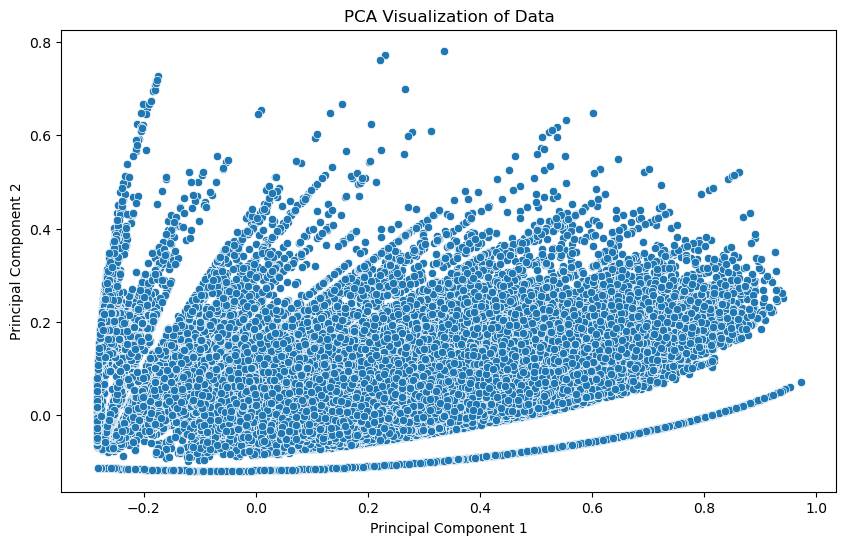

In [40]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=pca_df2)
plt.title('PCA Visualization of Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [41]:
print(f'Total variance: {np.sqrt(np.std(X_train_transformed2)).iloc[0]:.4f}')
print(f'Explained variance: {pca2_2.explained_variance_[0]:.4f}')
print(pca2_2.explained_variance_ratio_)

Total variance: 0.3366
Explained variance: 0.0677
[0.82018547 0.16568073]


 We did not observe distinct clusters when analyzing the reduced dataset. Therefore, we decided to proceed with feature engineering on the entire dataset. By enriching the dataset with additional features derived from speed and acceleration, we hope to improve the accuracy and robustness of our classification model.

## PCA

In [42]:
# PCA for 2 components
pca2 = PCA(n_components=2)
principal_components = pca2.fit_transform(X_train_transformed)

In [43]:
print(f'Total variance: {np.sqrt(np.std(X_train_transformed)).iloc[0]:.4f}')
print(f'Explained variance: {pca2.explained_variance_[0]:.4f}')
print(pca2.explained_variance_ratio_)

Total variance: 0.9989
Explained variance: 22.3221
[0.25732271 0.23713942]


In [44]:
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

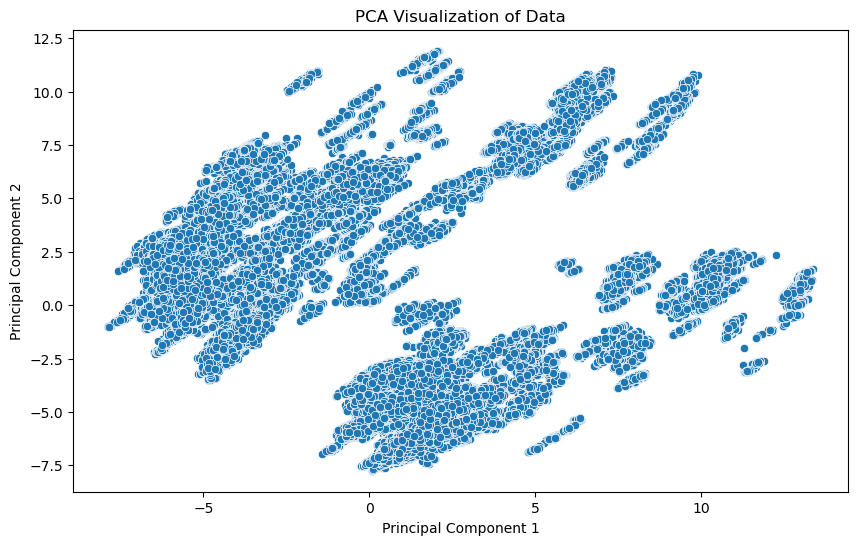

In [45]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=pca_df)
plt.title('PCA Visualization of Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [46]:
# PCA for 3 components
pca3 = PCA(n_components=3)
principal_components = pca3.fit_transform(X_train_transformed)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])

In [47]:
print(f'Total variance: {np.sqrt(np.std(X_train_transformed)).iloc[0]:.4f}')
print(f'Explained variance: {pca3.explained_variance_[0]:.4f}')
print(pca3.explained_variance_ratio_)

Total variance: 0.9989
Explained variance: 22.3221
[0.25732271 0.23713942 0.09290253]


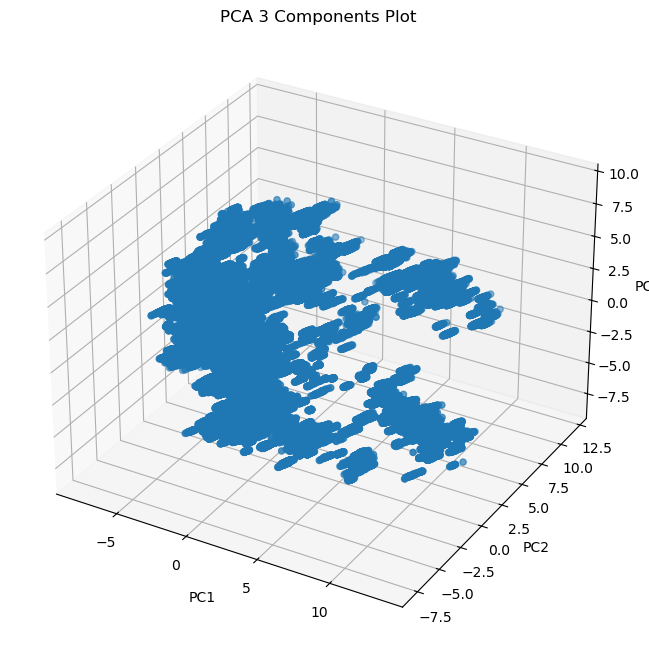

In [48]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA 3 Components Plot')
plt.show()

Text(0, 0.5, 'cumulative explained variance')

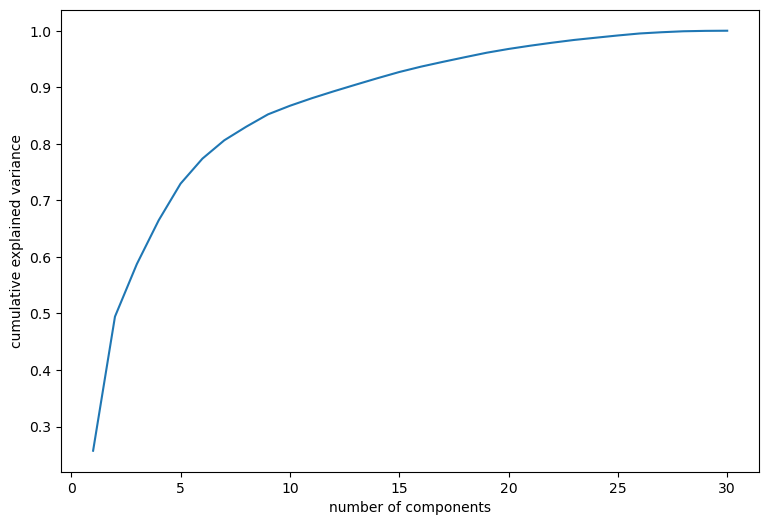

In [49]:
# We can observe that for approximately 20 components, we achieve a cumulative explained variance ratio of about 95%. 

pca = PCA().fit(X_train_transformed)

plt.figure(figsize=(9,6))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [50]:
# with 15 components we get cumulative explained variance at 0.95
num_components = 15

pca = PCA(n_components=num_components)
X_pca_reduced = pca.fit_transform(X_train_transformed)

In [51]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca_reduced)
X_train_transformed['cluster'] = clusters

In [52]:
sample_size = min(10000, len(X_pca_reduced))
indices = np.random.choice(len(X_pca_reduced), sample_size, replace=False)
X_sample = X_pca_reduced[indices]
clusters_sample = clusters[indices]

silhouette_avg = silhouette_score(X_sample, clusters_sample)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.3184066483184215


In [53]:
db_index = davies_bouldin_score(X_pca_reduced, clusters)
print(f"Davies-Bouldin Index: {db_index}")

Davies-Bouldin Index: 1.2610664866029753


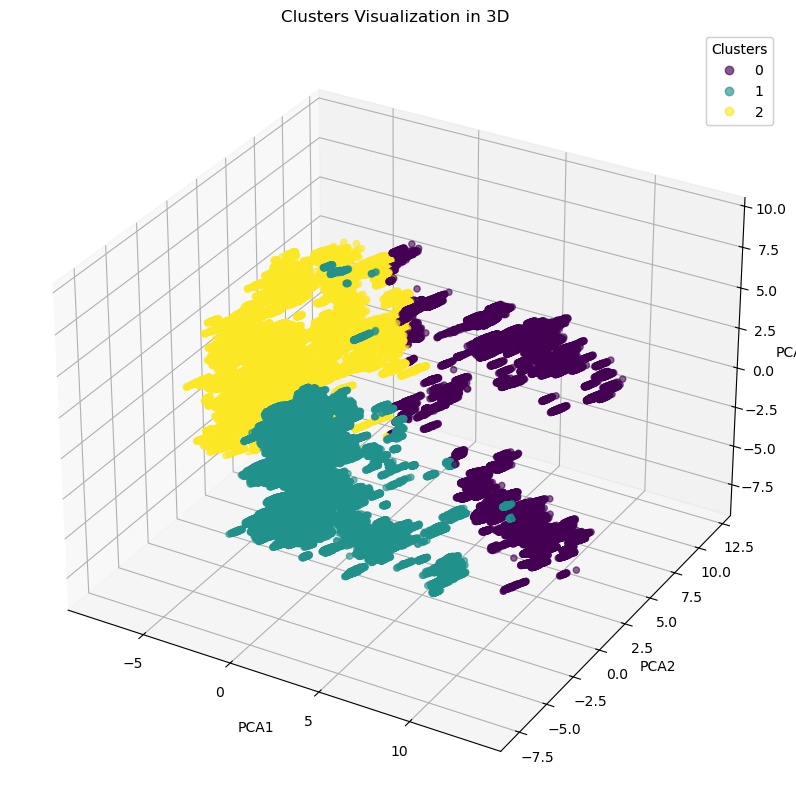

In [54]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca_reduced[:, 0], X_pca_reduced[:, 1], X_pca_reduced[:, 2], c=clusters, cmap='viridis', alpha=0.6)

ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('Clusters Visualization in 3D')

legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()

# Niepoprawny wybór konkretnej liczby klastrów - powinno to być sprawdzone np metodą łokcia

In [ ]:
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)

gmm.fit(X_pca_reduced)
clusters = gmm.predict(X_pca_reduced)

In [56]:
sample_size = min(10000, len(X_pca_reduced))
indices = np.random.choice(len(X_pca_reduced), sample_size, replace=False)
X_sample = X_pca_reduced[indices]
clusters_sample = clusters[indices]

silhouette_avg = silhouette_score(X_sample, clusters_sample)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.31585052261792473


In [57]:
davies_bouldin = davies_bouldin_score(X_pca_reduced, clusters)
print(f"Davis-Bouldin Index: {davies_bouldin}")

Davis-Bouldin Index: 1.271175956320312


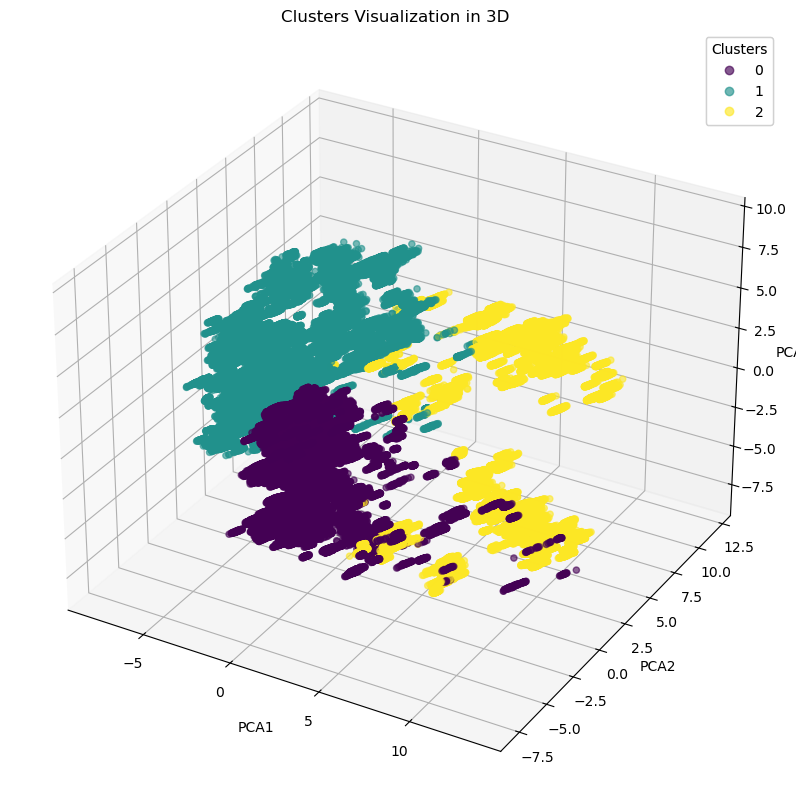

In [58]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca_reduced[:, 0], X_pca_reduced[:, 1], X_pca_reduced[:, 2], c=clusters, cmap='viridis', alpha=0.6)

ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('Clusters Visualization in 3D')

legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()

In [59]:
%%time

X_train_transformed_sample2 = resample(X_pca_reduced, n_samples=100000, random_state=42)

tSNE2 = TSNE(random_state=42, verbose=1)
digits_proj_sample2 = tSNE2.fit_transform(X_train_transformed_sample2)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100000 samples in 0.527s...
[t-SNE] Computed neighbors for 100000 samples in 50.170s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE] Computed conditional probab

In [60]:
kmeans2 = KMeans(n_clusters=3, random_state=42)
clusters2 = kmeans2.fit_predict(digits_proj_sample2)

In [61]:
print("Number of components after dimensionality reduction:", digits_proj_sample2.shape)


Number of components after dimensionality reduction: (100000, 2)


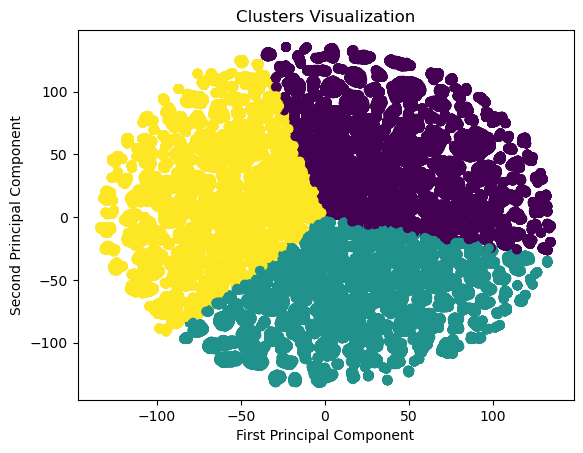

In [62]:
plt.scatter(digits_proj_sample2[:, 0], digits_proj_sample2[:, 1], c=clusters2, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Clusters Visualization')
plt.show()

In [63]:
sample_size2 = min(10000, len(digits_proj_sample2))
indices2 = np.random.choice(len(digits_proj_sample2), sample_size2, replace=False)
X_sample2 = digits_proj_sample2[indices2]
clusters_sample2 = clusters2[indices2]

silhouette_avg2 = silhouette_score(X_sample2, clusters_sample2)
print(f"Silhouette Score: {silhouette_avg2}")

Silhouette Score: 0.36395278573036194


In [64]:
inertia2 = kmeans2.inertia_
print(f"Inertia: {inertia2}")

Inertia: 305125440.0


In [65]:
db_index2 = davies_bouldin_score(digits_proj_sample2, clusters2)
print(f"Davies-Bouldin Index: {db_index2}")

Davies-Bouldin Index: 0.8813549653322879


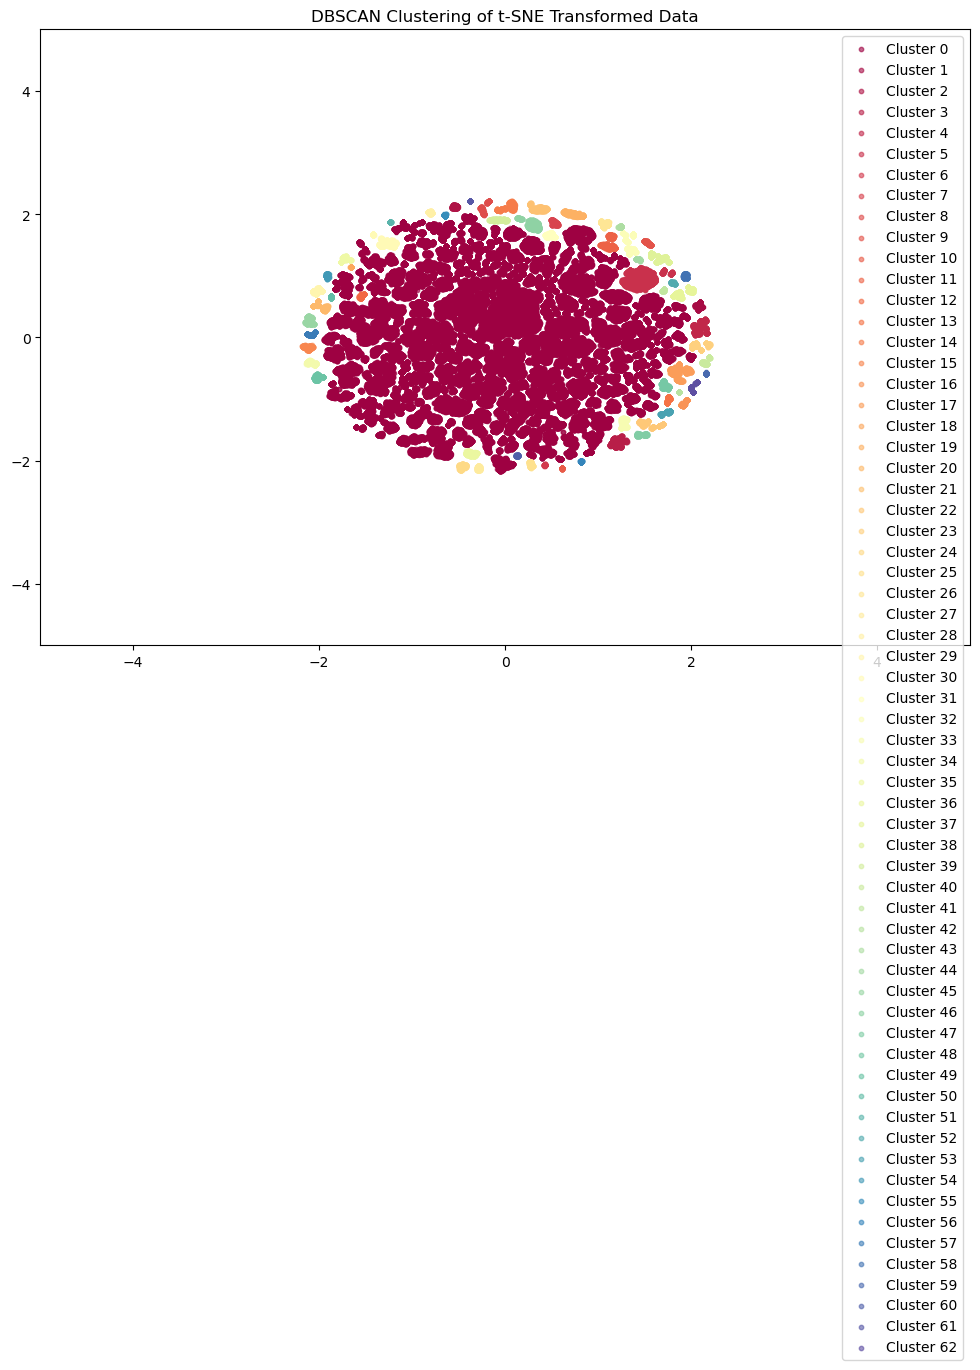

In [66]:
scaler = StandardScaler()
digits_proj_sample2 = scaler.fit_transform(digits_proj_sample2)

dbscan = DBSCAN(eps=0.1, min_samples=1)
dbscan_labels = dbscan.fit_predict(digits_proj_sample2)

plt.figure(figsize=(12, 8))
unique_labels = set(dbscan_labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]

    class_member_mask = (dbscan_labels == k)

    xy = digits_proj_sample2[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], s=10, color=tuple(col), label=f'Cluster {k}', alpha=0.6)

plt.title('DBSCAN Clustering of t-SNE Transformed Data')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.legend()
plt.show()

## TSNE

In [67]:
def scatter_tsne(x):
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')

    unique_colors = np.linspace(0, 1, len(x))
    palette = plt.cm.rainbow(unique_colors)

    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette)

    plt.xlim(np.min(x[:,0])-0.1, np.max(x[:,0])+0.1)
    plt.ylim(np.min(x[:,1])-0.1, np.max(x[:,1])+0.1)
    
    ax.axis('off')
    ax.axis('tight')

    return f, ax, sc

In [68]:
%%time

X_train_transformed_sample = resample(X_train_transformed, n_samples=100000, random_state=42)

tSNE = TSNE(random_state=42, verbose=1)
digits_proj_sample = tSNE.fit_transform(X_train_transformed_sample)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100000 samples in 0.015s...
[t-SNE] Computed neighbors for 100000 samples in 21.593s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE] Computed conditional probab

(<Figure size 800x800 with 1 Axes>,
 <Axes: >,
 <matplotlib.collections.PathCollection at 0x21e0437e450>)

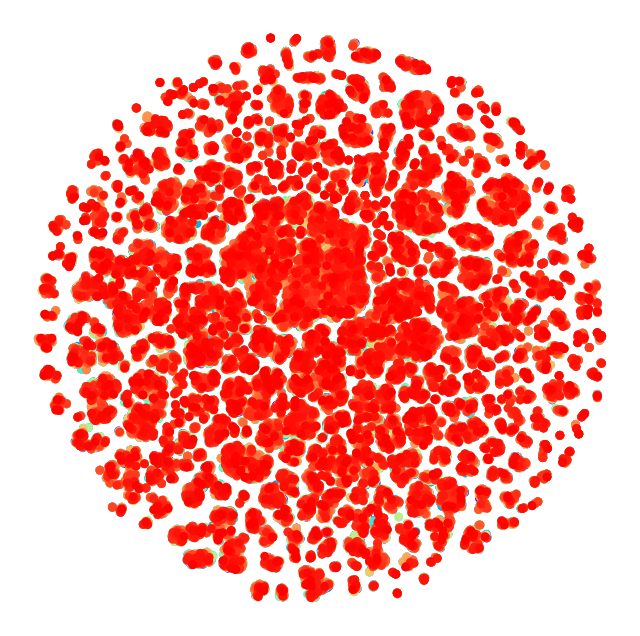

In [69]:
scatter_tsne(digits_proj_sample2)

## PCA for each device

In [70]:
# We categorize the data based on the originating device.

devices = {
    'location_group': [ 'seconds_elapsed_location', 'bearingAccuracy_location',
                        'speedAccuracy_location', 'verticalAccuracy_location',
                        'horizontalAccuracy_location', 'speed_location', 'bearing_location',
                        'altitude_location', 'longitude_location', 'latitude_location'],
    'orientation_group': ['seconds_elapsed_orientation', 'qz_orientation',
                        'qy_orientation', 'qx_orientation', 'qw_orientation',
                        'roll_orientation', 'pitch_orientation', 'yaw_orientation',],
    'total_acceleration_group': ['seconds_elapsed_total_acceleration', 'z_total_acceleration',
                        'y_total_acceleration', 'x_total_acceleration'],
    'magentometer_group':['seconds_elapsed_magnetometer', 'z_magnetometer', 'y_magnetometer',
                         'x_magnetometer'],
    'accelerometer_group':['seconds_elapsed_accelerometer', 'z_accelerometer',
                        'y_accelerometer', 'x_accelerometer'],
    'location_gps_group':['seconds_elapsed_location_gps',
                    'bearingAccuracy_location_gps', 'speedAccuracy_location_gps',
                    'verticalAccuracy_location_gps', 'horizontalAccuracy_location_gps',
                    'speed_location_gps', 'bearing_location_gps', 'altitude_location_gps',
                    'longitude_location_gps', 'latitude_location_gps'],
    'gyroscope_group':['seconds_elapsed_gyroscope', 'z_gyroscope', 'y_gyroscope',
                    'x_gyroscope'],
    'pedometer_group':['seconds_elapsed_pedometer', 'steps_pedometer'],
    'location_network_group':['seconds_elapsed_location_network', 'bearingAccuracy_location_network',
                    'speedAccuracy_location_network', 'verticalAccuracy_location_network',
                    'horizontalAccuracy_location_network', 'speed_location_network',
                    'bearing_location_network', 'altitude_location_network',
                    'longitude_location_network', 'latitude_location_network'],
    'gravity_group':['seconds_elapsed_gravity', 'z_gravity', 'y_gravity', 'x_gravity']
}

In [71]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.columns]

In [72]:
# Decision to use PCA for each device:
# The first step involves applying PCA to the data from each device, retaining only their first component.
# Utilizing PCA is advantageous as it enables dimensionality reduction and eliminates correlations between variables,
# which is particularly crucial for data originating from different sensors that may have varying scales and units.
# Retaining only the first component preserves the most significant features of the data while reducing its dimensionality.
# Subsequently, based on the PCA results for each device, we conduct the final transformation
# into a two-dimensional space using PCA, enabling data visualization and analysis of patterns across devices.

In [73]:
group_pca_results = pd.DataFrame()
for group_name, columns in devices.items():
    pipeline = Pipeline([
        ('outlier_handler', OutlierHandlerTransformer(columns=['speedAccuracy_location', 
                                          'horizontalAccuracy_location', 
                                          'verticalAccuracy_location', 
                                          'speed_location',
                                          'speedAccuracy_location_gps', 
                                          'verticalAccuracy_location_gps', 
                                          'horizontalAccuracy_location_gps', 
                                          'altitude_location_network',
                                          'verticalAccuracy_location_network', 
                                          'horizontalAccuracy_location_network', 
                                          'altitude_location_network'])),
        ('selector', ColumnSelector(columns=columns)),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=1))
    ])
    pca_result = pipeline.fit_transform(X_train)
    group_pca_results[group_name] = pca_result.flatten()


In [74]:
group_pca_results

,location_group,orientation_group,total_acceleration_group,magentometer_group,accelerometer_group,location_gps_group,gyroscope_group,pedometer_group,location_network_group,gravity_group
0,-1.592678,0.159918,-0.203777,-1.716736,-0.498538,-0.075723,-0.675294,-0.638236,-0.985151,1.106509
1,1.760517,0.471976,-0.117674,-0.228990,0.445823,-1.629272,0.072948,-0.179047,2.443381,0.414633
2,1.845928,-2.649804,-1.455111,1.800705,-0.020899,1.750686,0.017552,-2.044720,-0.898789,-1.637012
3,-1.362920,0.717161,1.325578,0.445891,-3.305104,1.391881,3.500825,-1.297853,-0.769268,0.714393
4,-2.035312,2.125404,2.353734,-0.306589,-3.428724,-0.494974,3.119954,-0.565684,-0.699721,1.246287
...,...,...,...,...,...,...,...,...,...,...
661524,-2.183466,0.702504,0.380247,1.173536,0.191267,-0.490969,0.158332,-0.161795,-0.741535,0.492538
661525,-2.138580,0.480085,0.677457,-1.864118,0.936189,0.222473,0.786581,-0.454533,-1.084193,2.057856
661526,-2.004415,1.149527,1.311511,-0.155578,-0.187167,0.185837,2.236596,-1.172432,-0.793404,1.436300
661527,1.764286,0.605778,0.235777,0.371194,-0.761795,-1.239287,0.183403,-0.455185,1.865475,0.511893


In [75]:
pca_per_device = PCA(n_components=2)
final_pca_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('final_pca', pca_per_device)
])

In [76]:
final_pca_transformed = final_pca_pipeline.fit_transform(group_pca_results)
final_pca_df = pd.DataFrame(final_pca_transformed, columns=['PC1', 'PC2'])

In [77]:
print(f'Total variance: {np.sqrt(np.std(group_pca_results)).iloc[0]:.4f}')
print(f'Explained variance: {pca_per_device.explained_variance_[0]:.4f}')
print(pca_per_device.explained_variance_ratio_)

Total variance: 1.2898
Explained variance: 4.8193
[0.4819268  0.12291027]


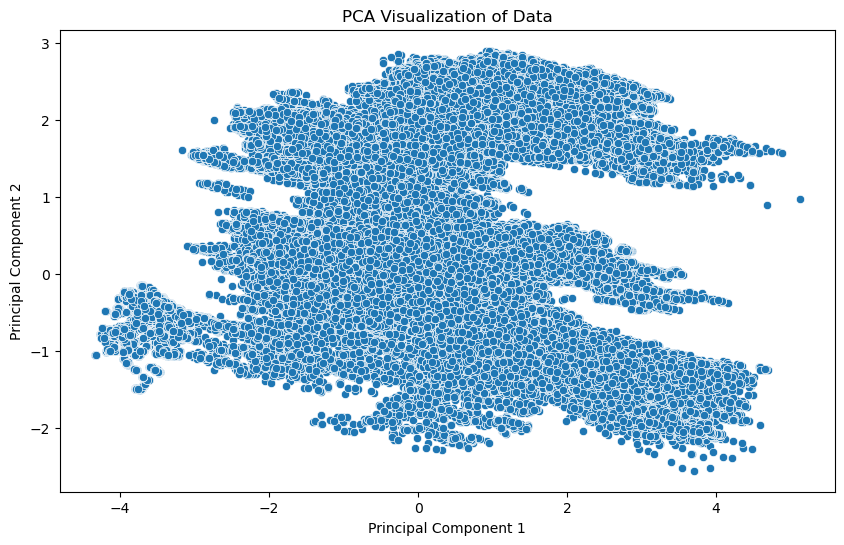

In [78]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=final_pca_df)
plt.title('PCA Visualization of Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [79]:
pca_per_device_test = PCA().fit(group_pca_results)

Text(0, 0.5, 'cumulative explained variance')

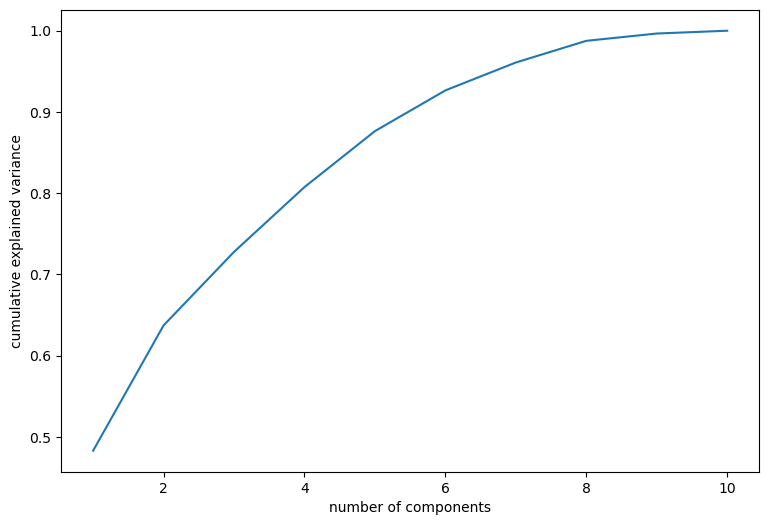

In [80]:
plt.figure(figsize=(9,6))
plt.plot(range(1, len(pca_per_device_test.explained_variance_ratio_)+1), np.cumsum(pca_per_device_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

## Testing models

In [81]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(final_pca_df)

labels = kmeans.labels_
print(labels)

[1 0 2 ... 1 0 1]


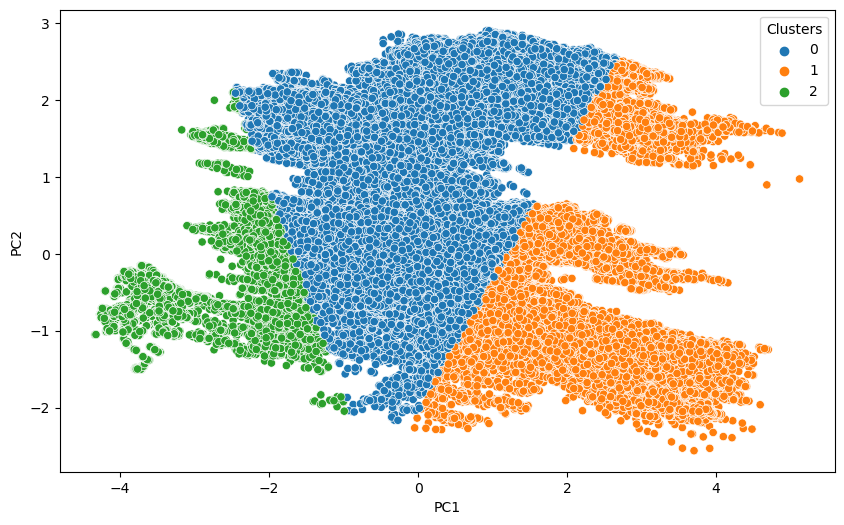

In [82]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=final_pca_df['PC1'], y=final_pca_df['PC2'], hue=labels, palette='tab10')
plt.legend(title='Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [83]:
# Due to performance issues, we're using only a sample of the data, as running DBSCAN on 
# 1.5 million records caused the kernel to crash.

sampled_data = final_pca_df.sample(n=20000, random_state=42)
dbscan = DBSCAN(eps=0.3, min_samples=4)
dbscan.fit(sampled_data)
db_labels = dbscan.labels_
print(db_labels)

[0 0 0 ... 0 0 0]


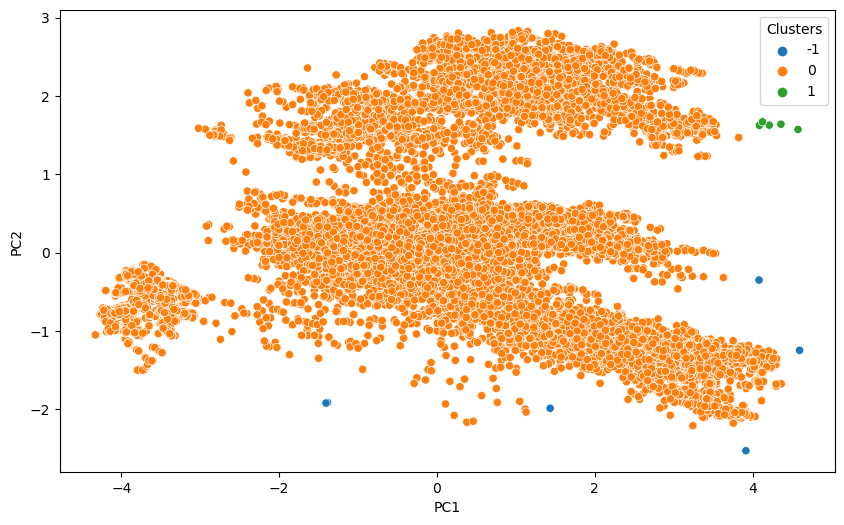

In [84]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=sampled_data['PC1'], y=sampled_data['PC2'], hue=db_labels, palette='tab10')
plt.legend(title='Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### Comment on PCA Approach for Devices

Initially, we considered a strategy where we would apply Principal Component Analysis (PCA) to each device separately, extracting just one component per device. Subsequently, we planned to apply another PCA on these extracted components. However, we decided to drop this idea because we observed that too much information is lost in the first steps of our analysis. By reducing each device's data to a single component, we lose significant variance and essential information, which negatively impacts the overall analysis and clustering results. Therefore, we are opting for a more comprehensive dimensionality reduction approach that retains more information from the original data.


## Testing dimensionality reduction methods on different models

In our initial exploration, we found that basic PCA did not yield satisfactory results when applied directly to our dataset. Therefore, we are now experimenting with alternative dimensionality reduction techniques to assess their impact on the performance of clustering algorithms. By testing methods such as t-SNE and UMAP, we aim to discover if these approaches can capture more complex relationships in the data, potentially leading to improved clustering outcomes. This iterative process allows us to iteratively refine our analysis and select the most suitable combination of dimensionality reduction and clustering algorithms for our dataset.


In [85]:
def test_clustering_algorithms(X, cluster_num=3):
    results = []

    kmeans = KMeans(n_clusters=cluster_num)
    labels_kmeans = kmeans.fit_predict(X)
    sil_score_kmeans = silhouette_score(X, labels_kmeans)
    db_score_kmeans = davies_bouldin_score(X, labels_kmeans)
    ch_score_kmeans = calinski_harabasz_score(X, labels_kmeans)
    inertia_kmeans = kmeans.inertia_
    results.append(('KMeans', sil_score_kmeans, db_score_kmeans, ch_score_kmeans, inertia_kmeans))

    gmm = GaussianMixture(n_components=cluster_num)
    labels_gmm = gmm.fit_predict(X)
    sil_score_gmm = silhouette_score(X, labels_gmm)
    db_score_gmm = davies_bouldin_score(X, labels_gmm)
    ch_score_gmm = calinski_harabasz_score(X, labels_gmm)
    results.append(('GMM', sil_score_gmm, db_score_gmm, ch_score_gmm, None))
    
    agglo = AgglomerativeClustering(n_clusters=cluster_num)
    labels_agglo = agglo.fit_predict(X)
    sil_score_agglo = silhouette_score(X, labels_agglo)
    db_score_agglo = davies_bouldin_score(X, labels_agglo)
    ch_score_agglo = calinski_harabasz_score(X, labels_gmm)
    results.append(('Agglomerative', sil_score_agglo, db_score_agglo, ch_score_agglo, None))

    return pd.DataFrame(results, columns=['Algorithm', 'Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Score', 'Inertia'])

In [86]:
sample_size = 10000
X_sampled = X_train_transformed.sample(n=sample_size, random_state=42)

In [87]:
pca = PCA(n_components=15) #min 15 components to get ~0.95 cumulative explained variance
X_pca_reduced = pca.fit_transform(X_sampled)
results_pca = test_clustering_algorithms(X_pca_reduced)
print("PCA Results:")
print(results_pca)

PCA Results:
       Algorithm  Silhouette Score  Davies-Bouldin Index  \
0         KMeans          0.321931              1.250316   
1            GMM          0.313330              1.260647   
2  Agglomerative          0.314454              1.294801   

   Calinski-Harabasz Score        Inertia  
0              3985.846315  451610.750933  
1              3842.528388            NaN  
2              3842.528388            NaN  


In [88]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne_reduced = tsne.fit_transform(X_sampled)
results_tsne = test_clustering_algorithms(X_tsne_reduced)
print("t-SNE Results:")
print(results_tsne)

t-SNE Results:
       Algorithm  Silhouette Score  Davies-Bouldin Index  \
0         KMeans          0.373406              0.869240   
1            GMM          0.368778              0.882242   
2  Agglomerative          0.331610              0.907498   

   Calinski-Harabasz Score     Inertia  
0              7475.999808  15705975.0  
1              7270.177326         NaN  
2              7270.177326         NaN  


# problem z działaniem kodu - moduł umap

In [100]:
umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_umap_reduced = umap_reducer.fit_transform(X_sampled)
results_umap = test_clustering_algorithms(X_umap_reduced)
print("UMAP Results:")
print(results_umap)

AttributeError: module 'umap' has no attribute 'UMAP'

In [99]:
%pip install umap

Note: you may need to restart the kernel to use updated packages.


In [90]:
tsne_pca = TSNE(n_components=2, random_state=42)
X_tsne_pca_reduced = tsne_pca.fit_transform(X_pca_reduced)
results_tsne_pca = test_clustering_algorithms(X_tsne_pca_reduced)
print("PCA-TSNE Results:")
print(results_tsne_pca)

PCA-TSNE Results:
       Algorithm  Silhouette Score  Davies-Bouldin Index  \
0         KMeans          0.370896              0.886370   
1            GMM          0.361224              0.915446   
2  Agglomerative          0.356091              0.926957   

   Calinski-Harabasz Score     Inertia  
0              7395.832937  16125258.0  
1              6976.979439         NaN  
2              6976.979439         NaN  


In [91]:
# umap information

def calculate_distance_correlation(X_original, X_reduced):
    original_distances = pdist(X_original, metric='euclidean')
    reduced_distances = pdist(X_reduced, metric='euclidean')
    correlation = np.corrcoef(original_distances, reduced_distances)[0, 1]
    return correlation

component_range = range(2, 22)
correlations = []

for n_components in component_range:
    umap_reducer = umap.UMAP(n_components=n_components, random_state=42)
    X_umap_reduced = umap_reducer.fit_transform(X_sampled)
    correlation = calculate_distance_correlation(X_sampled, X_umap_reduced)
    correlations.append(correlation)
    print(f"Components: {n_components}, Distance Correlation: {correlation}")

plt.figure(figsize=(10, 6))
plt.plot(component_range, correlations, marker='o')
plt.title('UMAP Distance Correlation vs. Number of Components')
plt.xlabel('Number of UMAP Components')
plt.ylabel('Distance Correlation')
plt.grid(True)
plt.show()

optimal_components = component_range[np.argmax(correlations)]
print(f"Optimal number of UMAP components: {optimal_components}")

AttributeError: module 'umap' has no attribute 'UMAP'

PCA with 4 components was considered as an alternative for dimensionality reduction. However, based on the evaluation metrics such as Silhouette Score and Davies-Bouldin Index, UMAP was chosen as the preferred method. UMAP's flexibility in preserving both global and local structures of the data is expected to yield better clustering results.


In [96]:
pca = PCA(n_components=15) #min 15 components to get ~0.95 cumulative explained variance
X_pca = pca.fit_transform(X_train_transformed)

In [97]:
def min_interclust_dist(X, label):
    clusters = set(label)
    global_min_dist = np.inf
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        for cluster_j in clusters:
            if cluster_i != cluster_j:
                cluster_j_idx = np.where(label == cluster_j)
                interclust_min_dist = np.min(distance.cdist(X[cluster_i_idx], X[cluster_j_idx]))
                global_min_dist = np.min([global_min_dist, interclust_min_dist])
    return global_min_dist

def _inclust_mean_dists(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        inclust_dist = np.mean(distance.pdist(X[cluster_i_idx]))
        inclust_dist_list.append(inclust_dist)
    return inclust_dist_list

def mean_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.mean(inclust_dist_list)

def std_dev_of_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.std(inclust_dist_list)

def mean_dist_to_center(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        cluster_i_mean = np.mean(X[cluster_i_idx], axis=0, keepdims=True)
        inclust_dist = np.mean(distance.cdist(X[cluster_i_idx], cluster_i_mean))
        inclust_dist_list.append(inclust_dist)
    return np.mean(inclust_dist_list)


def count_clustering_scores(X, cluster_num, model, score_fun):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

In [98]:
metrices = {
            'min dist between clusters': min_interclust_dist,
            'mean dist in clust': mean_inclust_dist,
            'std dev dist in clust': std_dev_of_inclust_dist,
            'mean dist to clust center': mean_dist_to_center,
            'silhouette': silhouette_score,
            'davies bouldin': davies_bouldin_score,
            'calinski harabasz': calinski_harabasz_score, 
           }

models = {
          'Kmeans': KMeans,
          'Agglomerative ward linkage': partial(AgglomerativeClustering, linkage='ward'),
          'Agglomerative complete linkage': partial(AgglomerativeClustering, linkage='complete'),
          'Agglomerative average linkage': partial(AgglomerativeClustering, linkage='average'),
          'Agglomerative single linkage': partial(AgglomerativeClustering, linkage='single')
         }


df = pd.DataFrame()
for model_key in models:
    for metric_key in metrices:
        df.loc[model_key, metric_key] = count_clustering_scores(X=X_pca, cluster_num=3,
                                                                model=models[model_key],
                                                                score_fun=metrices[metric_key])

MemoryError: Unable to allocate 268. GiB for an array with shape (131062, 274314) and data type float64

In [ ]:
df

,min dist between clusters,mean dist in clust,std dev dist in clust,mean dist to clust center,silhouette,davies bouldin,calinski harabasz
Kmeans,0.999975,0.080725,0.017613,0.06094,0.927821,0.126993,951185.289814
Agglomerative ward linkage,0.999975,0.080725,0.017613,0.06094,0.927821,0.126993,951185.289814
Agglomerative complete linkage,0.999975,0.080725,0.017613,0.06094,0.927821,0.126993,951185.289814
Agglomerative average linkage,0.999975,0.080725,0.017613,0.06094,0.927821,0.126993,951185.289814
Agglomerative single linkage,0.999975,0.080725,0.017613,0.06094,0.927821,0.126993,951185.289814


### Now, let's try applying KMeans and Agglomerative Clustering with average linkage method since they appear to yield the best results on our sample dataset.


In [101]:
# 10k sample -> 100k sample

sample_size = 100000
X_sampled_100 = X_train_transformed.sample(n=sample_size, random_state=42)

In [102]:
pca_reducer = PCA(n_components=15, random_state=42)
X_pca_reduced100 = pca_reducer.fit_transform(X_train_transformed)

In [103]:
kmeans_pca = KMeans(n_clusters=3, random_state=42)
clusters_pca = kmeans_pca.fit_predict(X_pca_reduced100)

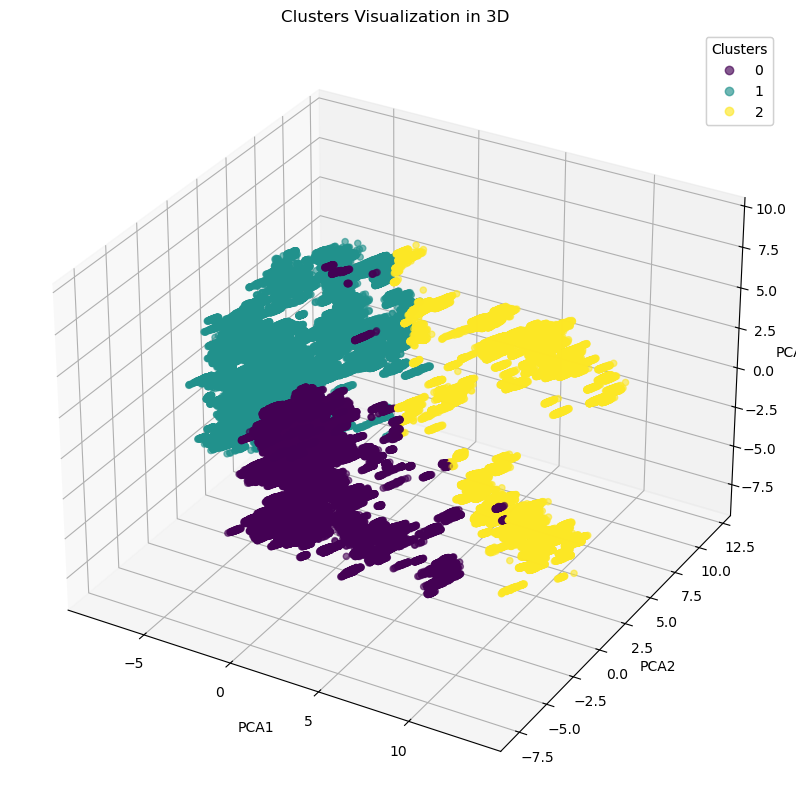

In [104]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca_reduced100[:, 0], X_pca_reduced100[:, 1], X_pca_reduced100[:, 2], c=clusters_pca, cmap='viridis', alpha=0.6)

ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('Clusters Visualization in 3D')

legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()

In [105]:
sample_size = min(10000, len(X_pca_reduced100))
indices = np.random.choice(len(X_pca_reduced100), sample_size, replace=False)
X_sample = X_pca_reduced100[indices]
clusters_sample = clusters_pca[indices]

silhouette_avg = silhouette_score(X_sample, clusters_sample)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.32079071134317194


In [106]:
db_index = davies_bouldin_score(X_pca_reduced100, clusters_pca)
print(f"Davies-Bouldin Index: {db_index}")

Davies-Bouldin Index: 1.2540074249469335


In [107]:
X_train.columns

Index(['time', 'seconds_elapsed_orientation', 'qz_orientation',
       'qy_orientation', 'qx_orientation', 'qw_orientation',
       'roll_orientation', 'pitch_orientation', 'yaw_orientation',
       'seconds_elapsed_location', 'bearingAccuracy_location',
       'speedAccuracy_location', 'verticalAccuracy_location',
       'horizontalAccuracy_location', 'speed_location', 'bearing_location',
       'altitude_location', 'longitude_location', 'latitude_location',
       'seconds_elapsed_total_acceleration', 'z_total_acceleration',
       'y_total_acceleration', 'x_total_acceleration',
       'seconds_elapsed_magnetometer', 'z_magnetometer', 'y_magnetometer',
       'x_magnetometer', 'seconds_elapsed_accelerometer', 'z_accelerometer',
       'y_accelerometer', 'x_accelerometer', 'seconds_elapsed_location_gps',
       'bearingAccuracy_location_gps', 'speedAccuracy_location_gps',
       'verticalAccuracy_location_gps', 'horizontalAccuracy_location_gps',
       'speed_location_gps', 'bearing_l

In [108]:
X_train['cluster'] = clusters_pca

In [109]:
pipeline_interpretaction = Pipeline(steps=[
    ('outlier_handler', OutlierHandlerTransformer(columns=['speedAccuracy_location', 
                                          'horizontalAccuracy_location', 
                                          'verticalAccuracy_location', 
                                          'speed_location',
                                          'speedAccuracy_location_gps', 
                                          'verticalAccuracy_location_gps', 
                                          'horizontalAccuracy_location_gps', 
                                          'altitude_location_network',
                                          'verticalAccuracy_location_network', 
                                          'horizontalAccuracy_location_network', 
                                          'altitude_location_network'])),
    ('dropper', ColumnDropper(columns=["seconds_elapsed_time_pedometer","bearingAccuracy_location_network", 
                                        "speedAccuracy_location_network", 
                                        "speed_location_network", 
                                        "bearing_location_network",'qz_orientation', 'qy_orientation',
                                        'qx_orientation', 'qw_orientation'
                                        'verticalAccuracy_location_network',
                                        'horizontalAccuracy_location_network'
                                        ])),
    ('average_seconds_elapsed', AverageSecondsElapsedTransformer()),
    ('average_speed_transformer', AverageSpeedTransformer()),
    ('average_location_transformer', AverageLocationTransformer()),
    ('acceleration_magnitude_transformer', AccelerationMagnitudeTransformer()),
    ('magnetometer_magnitude_transformer', MagnetometerMagnitudeTransformer()),
    ('gyroscope_integration_transformer', GyroscopeIntegrationTransformer()),
    ('gravitation_magnitude_transformer', GravitationMagnitudeTransformer()),
    ('accelerometer_magnitude_transformer', AccelerometerMagnitudeTransformer()),
    ('time_feature_extractor', TimeFeatureExtraction()),
    ('time_dropper', ColumnDropper(columns=['time'])),
    ('distance_calculator', DistanceCalculator()),
    ('sum_square', SumSquareFeatureExtractor('accelerometer_magnitude','speed'))
])

In [110]:
X_train_features = pipeline_interpretaction.fit_transform(X_train)

In [111]:
X_train_features.columns

Index(['qw_orientation', 'roll_orientation', 'pitch_orientation',
       'yaw_orientation', 'bearingAccuracy_location', 'speedAccuracy_location',
       'verticalAccuracy_location', 'horizontalAccuracy_location',
       'bearing_location', 'bearingAccuracy_location_gps',
       'speedAccuracy_location_gps', 'verticalAccuracy_location_gps',
       'horizontalAccuracy_location_gps', 'bearing_location_gps',
       'steps_pedometer', 'verticalAccuracy_location_network', 'cluster',
       'seconds_elapsed_time', 'speed', 'longitude', 'latitude', 'altitude',
       'acceleration_magnitude', 'magnetometer_magnitude', 'angular_velocity',
       'gravitation_magnitude', 'accelerometer_magnitude', 'hour', 'minute',
       'distance', 'sum_square'],
      dtype='object')

In [112]:
cluster_summary = X_train_features.groupby('cluster').agg(['mean'])
columns_of_interest = [
    'steps_pedometer', 'verticalAccuracy_location_network',
    'seconds_elapsed_time', 'speed', 'longitude', 'latitude', 'altitude',
    'acceleration_magnitude', 'magnetometer_magnitude', 'angular_velocity',
    'gravitation_magnitude', 'accelerometer_magnitude', 'hour', 'minute',
    'distance', 'sum_square'
]

print(cluster_summary[columns_of_interest])

        steps_pedometer verticalAccuracy_location_network  \
                   mean                              mean   
cluster                                                     
0            601.758980                         11.735808   
1            819.050384                          8.461883   
2             65.591590                          2.134250   

        seconds_elapsed_time     speed longitude   latitude   altitude  \
                        mean      mean      mean       mean       mean   
cluster                                                                  
0                 356.922556  5.624863  3.118964  50.683632  74.166578   
1                 482.236643  1.927811  3.131399  50.682421  79.377038   
2                 259.404887  0.126877  3.097973  50.687844  65.717878   

        acceleration_magnitude magnetometer_magnitude angular_velocity  \
                          mean                   mean             mean   
cluster                                 

The cluster analysis performed on the given dataset has yielded satisfactory results, demonstrating distinct groupings primarily based on speed, which appears to be a significant factor in the clustering process.

### Summary of Cluster Characteristics

#### Cluster 0:
- **Steps Pedometer**: This cluster has a moderate average number of steps (599.56), indicating moderate physical activity.
- **Vertical Accuracy (Location Network)**: The vertical accuracy is moderate (11.71), suggesting an average precision in location data.
- **Seconds Elapsed Time**: This cluster shows a moderate amount of elapsed time (355.74 seconds).
- **Speed**: The average speed is moderate (5.62), which is a distinguishing characteristic of this cluster.
- **Longitude and Latitude**: The geographical coordinates are approximately 3.119 and 50.684 respectively.
- **Altitude**: The altitude is moderate (74.16).
- **Acceleration Magnitude**: This is relatively high (9.93), indicating noticeable movement.
- **Magnetometer Magnitude**: The magnetometer readings are the highest (49.76).
- **Angular Velocity**: The angular velocity is moderate (1.24), indicating rotational movement.
- **Gravitation Magnitude**: The gravitational magnitude is consistent across clusters (9.81).
- **Accelerometer Magnitude**: This is moderate (2.73), reinforcing the moderate activity level.
- **Hour and Minute**: The average time is around 8:21AM, suggesting early morning activity.
#### Cluster 1:
- **Steps Pedometer**: This cluster has the highest average number of steps (818.29), indicating high physical activity.
- **Vertical Accuracy (Location Network)**: The vertical accuracy is moderate (8.40).
- **Seconds Elapsed Time**: This cluster shows the highest elapsed time (481.73 seconds).
- **Speed**: The average speed is moderate (1.92), distinguishing this cluster from the others.
- **Longitude and Latitude**: The geographical coordinates are approximately 3.131 and 50.682 respectively.
- **Altitude**: The altitude is the highest among the clusters (79.36).
- **Acceleration Magnitude**: This is the highest (10.49), indicating significant movement.
- **Magnetometer Magnitude**: The magnetometer readings are moderate (48.70).
- **Angular Velocity**: The angular velocity is the highest (1.33), indicating considerable rotational movement.
- **Gravitation Magnitude**: The gravitational magnitude is consistent across clusters (9.81).
- **Accelerometer Magnitude**: This is the highest (3.82), reinforcing the high activity level.
- **Hour and Minute**: The average time is around 13:09 PM, suggesting mid-day activity.
#### Cluster 2:
- **Steps Pedometer**: This cluster has the lowest average number of steps (66.71), indicating minimal physical activity.
- **Vertical Accuracy (Location Network)**: The vertical accuracy is the highest (2.12), suggesting higher precision in location data.
- **Seconds Elapsed Time**: This cluster shows the lowest elapsed time (260.20 seconds).
- **Speed**: The average speed is the lowest (0.13), which is a distinguishing characteristic of this cluster.
- **Longitude and Latitude**: The geographical coordinates are approximately 3.098 and 50.688 respectively.
- **Altitude**: The altitude is the lowest (65.74).
- **Acceleration Magnitude**: This is relatively high (9.73), indicating noticeable movement.
- **Magnetometer Magnitude**: The magnetometer readings are the lowest (47.75).
- **Angular Velocity**: The angular velocity is very low (0.05), indicating little to no rotational movement.
- **Gravitation Magnitude**: The gravitational magnitude is consistent across clusters (9.81).
- **Accelerometer Magnitude**: This is very low (0.17), reinforcing the low activity level.
- **Hour and Minute**: The average time is around 9:23 AM, suggesting morning activity.

### Conclusion

The clustering results are quite informative, indicating that the primary factor driving the clustering process is the speed of movement. Cluster 2 is characterized by low activity and speed, Cluster 1 by high activity and moderate speed, and Cluster 0 by moderate activity and high speed. This segmentation based on speed is logical and provides meaningful insights into the different types of activity patterns present in the dataset. The clear distinctions in other variables such as steps, altitude, and accelerometer magnitude further validate the robustness of the clustering. Overall, the results are satisfactory and highlight the effectiveness of the clustering approach in capturing the underlying patterns in the data.


In [115]:
X_test=pd.read_csv('../eda/X_test.csv')

In [116]:
X_test_transformed = pipeline.transform(X_test)
X_test_reduced = pca_reducer.transform(X_test_transformed)
clusters_pca_test = kmeans_pca.predict(X_test_reduced)

ValueError: X has 1 features, but PCA is expecting 31 features as input.

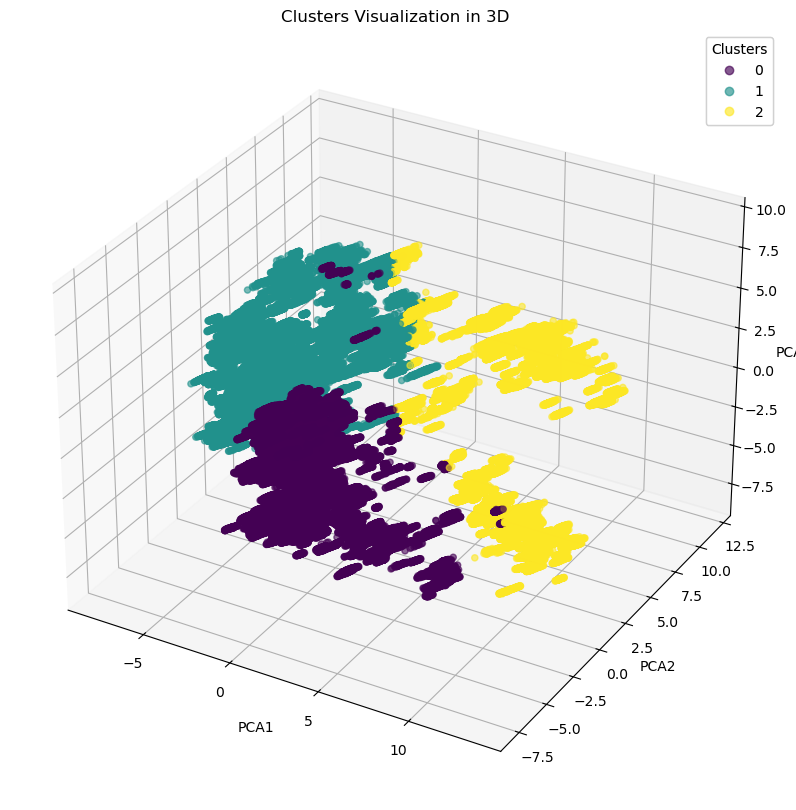

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_test_reduced[:, 0], X_test_reduced[:, 1], X_test_reduced[:, 2], c=clusters_pca_test, cmap='viridis', alpha=0.6)

ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('Clusters Visualization in 3D')

legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()

In [ ]:
X_test['cluster'] = clusters_pca_test
X_test_features = pipeline_interpretaction.fit_transform(X_test)
cluster_summary_test = X_test_features.groupby('cluster').agg(['mean'])

print(cluster_summary_test[columns_of_interest])

        steps_pedometer verticalAccuracy_location_network  \
                   mean                              mean   
cluster                                                     
0            601.280609                         11.729753   
1            819.303368                          8.425722   
2             67.610438                          2.121974   

        seconds_elapsed_time     speed longitude   latitude  altitude  \
                        mean      mean      mean       mean      mean   
cluster                                                                 
0                 356.686571  5.628944  3.118955  50.683639  74.15198   
1                 482.440456  1.917972  3.131440  50.682416  79.37847   
2                 260.564505  0.127642  3.098074  50.687840  65.76044   

        acceleration_magnitude magnetometer_magnitude angular_velocity  \
                          mean                   mean             mean   
cluster                                       

It seems that the data presents similar values for each variable across different clusters. There aren't clear differences in the mean values between clusters for most variables. For instance, the average values for "steps_pedometer", "verticalAccuracy_location_network", "seconds_elapsed_time", "speed", "longitude", "latitude", "altitude", "acceleration_magnitude", "magnetometer_magnitude", "angular_velocity", "gravitation_magnitude", "accelerometer_magnitude", "hour", "minute", "distance", and "sum_square" are similar across all three clusters. This might suggest that clusters are challenging to distinguish based on these variables in the test set. Additionally, differences between clusters might be more subtle or related to other variables not included in the analysis.

In [ ]:
clusters_pca_test

array([1, 1, 0, ..., 1, 0, 2])

In [ ]:
X_test_reduced

array([[-4.18166359, -0.97612656,  4.28896844],
       [-0.63949278,  6.06441666,  0.50347039],
       [ 0.89324016, -3.24432495, -1.85835005],
       ...,
       [-5.0499364 ,  1.35105375,  0.30497702],
       [ 0.67033005, -5.25991833, -4.01850503],
       [ 1.4732923 ,  3.49108337, -1.81948471]])

In [ ]:
X_test_transformed

,qw_orientation,roll_orientation,pitch_orientation,yaw_orientation,bearingAccuracy_location,speedAccuracy_location,verticalAccuracy_location,horizontalAccuracy_location,bearing_location,bearingAccuracy_location_gps,...,altitude,acceleration_magnitude,magnetometer_magnitude,angular_velocity,gravitation_magnitude,accelerometer_magnitude,hour,minute,distance,sum_square
0,-0.212803,0.372558,-0.294870,-0.408099,-5.199338,-5.199338,-0.035763,0.404051,0.604554,-0.142222,...,-0.724158,0.990531,-1.542859,0.162534,0.081991,0.190166,-5.199338,0.110627,-0.364662,-0.272318
1,-0.327935,-0.324058,-1.976511,-0.931457,-5.199338,-5.199338,-5.199338,5.199338,0.121995,5.199338,...,-0.977487,-0.208034,-0.833479,-2.080044,0.956418,-1.162852,-0.158740,0.025094,0.792987,-1.115580
2,0.132626,0.238273,-0.623141,1.371848,0.778225,0.568686,1.141756,0.339720,0.011529,-0.672129,...,0.667419,-1.409209,0.211529,0.733570,0.273721,0.826650,0.326900,-0.223916,-1.011900,0.587030
3,-1.629547,-1.843773,0.371707,0.133862,-5.199338,-5.199338,1.490268,0.278122,1.538144,-0.284828,...,-0.351017,0.720127,0.780398,-0.428570,1.867230,-0.177447,-5.199338,0.523537,0.333448,-0.023528
4,-0.559857,-0.280330,-1.417624,-1.008417,-5.199338,1.061884,-0.885167,-0.731515,-5.199338,5.199338,...,-1.571286,-0.210377,-0.904049,-1.189840,-1.496610,-1.150914,-0.158740,0.430727,0.926176,-1.444979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
945037,0.041558,-0.573245,0.183800,0.418635,1.044409,0.342823,0.217488,-0.731515,2.225823,-0.330873,...,-2.256745,-2.036502,1.637908,0.818250,0.620965,1.344588,-0.441766,1.368450,-0.678202,0.929145
945038,-0.498987,-0.094110,-1.314757,-0.792872,5.199338,1.128144,-1.095223,0.162552,0.291007,5.199338,...,-1.220640,0.043969,-0.736857,-1.630292,1.980431,-1.886544,0.326900,-1.525529,0.571324,-0.803631
945039,0.801452,0.682481,0.357235,1.395240,-5.199338,-5.199338,0.879040,0.506348,-0.070404,-0.122145,...,-0.152391,0.329207,-0.617672,-0.587211,-1.195181,-0.277977,0.326900,-0.333524,-0.953493,-0.270211
945040,-0.259930,-0.752342,-0.031668,0.215396,0.977487,0.700711,1.006211,-0.731515,1.473606,-0.440383,...,-1.029375,-2.186601,1.388695,0.995836,0.829510,1.421533,-0.441766,0.893908,-1.199088,1.634459


In [ ]:
clusters_pca

array([0, 0, 0, ..., 1, 1, 0])

In [ ]:
X_pca_reduced100

array([[-0.45616409, -4.15122792, -0.97580961, ..., -0.8690712 ,
         1.52137017, -0.83860928],
       [ 0.35255223, -2.817558  , -1.76455938, ...,  1.72265944,
         0.31290657,  1.2707346 ],
       [ 1.6445938 , -4.66559233, -4.06116956, ...,  1.07506965,
         0.43640281, -1.2870167 ],
       ...,
       [-5.46723962,  1.54400981, -0.12809498, ...,  2.02602027,
        -0.18478022, -0.80098556],
       [-5.81255242,  1.57460229, -0.63013785, ..., -0.40728592,
        -1.28363913,  0.813747  ],
       [ 1.63335908, -6.18359547,  2.79497752, ..., -0.47898666,
        -1.52558748, -0.5139703 ]])

In [ ]:
X_train_transformed

,qw_orientation,roll_orientation,pitch_orientation,yaw_orientation,bearingAccuracy_location,speedAccuracy_location,verticalAccuracy_location,horizontalAccuracy_location,bearing_location,bearingAccuracy_location_gps,...,acceleration_magnitude,magnetometer_magnitude,angular_velocity,gravitation_magnitude,accelerometer_magnitude,hour,minute,distance,sum_square,cluster
0,-1.286150,0.428890,0.043516,-1.499385,0.260089,-0.032625,0.527858,-0.716839,0.370743,-1.579968,...,-1.151088,-0.751554,0.301411,-0.813846,0.361051,0.332198,0.590949,-0.230775,0.718841,0
1,1.526179,0.753954,-0.008140,0.544046,0.736442,0.087933,0.414267,0.336178,-0.535597,-0.739737,...,0.610408,0.828296,-0.562667,-0.511849,-0.253734,0.332198,0.100535,-1.766516,0.121930,0
2,-1.145555,-0.746058,0.675760,0.133790,1.283135,1.310017,0.618059,-0.038232,1.384219,-0.016310,...,-0.988084,1.302339,0.090418,-1.187110,0.125035,-0.421111,0.955471,-0.930577,0.129035,0
3,1.317539,0.656255,-0.056814,0.685437,0.354822,-0.032625,0.759677,-0.716839,-0.256851,-1.310017,...,-0.810131,0.000886,-0.303820,-0.311052,-0.217634,0.332198,-0.471004,-1.031555,0.323702,0
4,-0.981733,-1.175320,-0.386609,-0.427050,-5.199338,-5.199338,-0.212920,-0.047153,0.501079,-0.568686,...,-0.917374,-1.527660,1.089284,2.338919,0.017245,-5.199338,0.100535,1.961000,0.460943,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543562,0.031698,1.290223,2.058944,-2.221376,1.554270,5.199338,-0.530348,0.211070,0.822328,0.673407,...,-0.111587,-1.306415,-0.773460,0.596575,-0.802110,1.123415,-0.334851,-0.642543,-0.717244,0
1543563,1.747243,0.976917,1.744272,1.043837,-5.199338,-5.199338,-0.275730,5.199338,0.195933,0.401542,...,-0.791475,-1.320997,1.510595,-0.241856,0.248698,1.123415,-0.901416,0.307606,-0.429825,1
1543564,1.180075,0.563703,-0.308545,0.296508,-5.199338,-5.199338,0.676854,0.597685,-0.709655,-0.177827,...,0.473006,0.487418,0.191468,-2.292861,0.298143,0.332198,0.018820,-2.488257,-0.224773,1
1543565,1.168500,-0.474885,1.183259,1.609460,-5.199338,-5.199338,-0.187961,1.645636,0.189296,0.381747,...,1.993143,-2.545329,0.947584,0.330858,1.762106,1.123415,-0.901416,0.327327,1.648766,1


In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
rf_model.fit(X_train_transformed, clusters_pca)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = rf_model.predict(X_test_transformed)

In [ ]:
accuracy = accuracy_score(clusters_pca_test, y_pred)
print(f'Model accuracy on the test set: {accuracy:.4f}')

Model accuracy on the test set: 0.9997


In [ ]:
print(classification_report(clusters_pca_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    366741
           1       1.00      1.00      1.00    390934
           2       1.00      1.00      1.00    187367

    accuracy                           1.00    945042
   macro avg       1.00      1.00      1.00    945042
weighted avg       1.00      1.00      1.00    945042



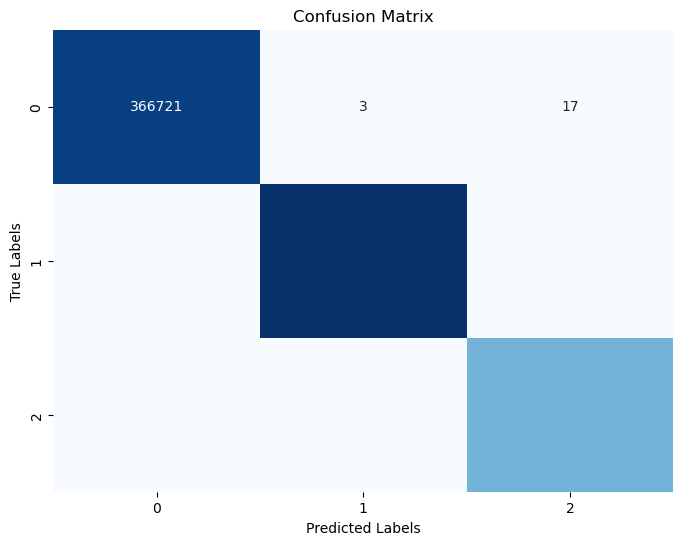

In [ ]:
cm = confusion_matrix(clusters_pca_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

print("Importance of features:")
for i in range(X_train_transformed.shape[1]):
    column_name = X_train_transformed.columns[indices[i]]
    print(f"Feature {column_name}: {importances[indices[i]]:.4f}")


Importance of features:
Feature speedAccuracy_location: 0.1818
Feature bearingAccuracy_location: 0.1558
Feature speed: 0.1144
Feature horizontalAccuracy_location: 0.0762
Feature longitude: 0.0672
Feature steps_pedometer: 0.0620
Feature bearingAccuracy_location_gps: 0.0480
Feature pitch_orientation: 0.0415
Feature accelerometer_magnitude: 0.0321
Feature sum_square: 0.0303
Feature latitude: 0.0293
Feature angular_velocity: 0.0263
Feature yaw_orientation: 0.0226
Feature bearing_location_gps: 0.0202
Feature distance: 0.0159
Feature bearing_location: 0.0158
Feature hour: 0.0135
Feature verticalAccuracy_location_gps: 0.0075
Feature seconds_elapsed_time: 0.0066
Feature verticalAccuracy_location: 0.0060
Feature speedAccuracy_location_gps: 0.0057
Feature qw_orientation: 0.0045
Feature horizontalAccuracy_location_gps: 0.0044
Feature minute: 0.0042
Feature roll_orientation: 0.0026
Feature altitude: 0.0023
Feature verticalAccuracy_location_network: 0.0020
Feature magnetometer_magnitude: 0.0008
Fea

### Feature Importance Summary:

1. **Highly Important Features**:
   - **speedAccuracy_location**: 0.1818
   - **bearingAccuracy_location**: 0.1558

2. **Moderately Important Features**:
   - **speed**: 0.1144
   - **horizontalAccuracy_location**: 0.0762

3. **Other Notable Features**:
   - **longitude**: 0.0672
   - **latitude**: 0.0293
   - **steps_pedometer**: 0.0620
   - **pitch_orientation**: 0.0415
   - **accelerometer_magnitude**: 0.0321
   - **sum_square**: 0.0303

4. **Less Important Features**:
   - **roll_orientation**: 0.0026
   - **altitude**: 0.0023
   - **magnetometer_magnitude**: 0.0008

This summary provides insights into the predictive power of different features in the model. Features with higher importance scores have more influence on the model's predictions.


### Decision on Kmeans

We chose K-means because it yielded satisfactory results. Other clustering algorithms showed similar outcomes for our sample data, but for example, Agglomerative Clustering had issues with convergence. We also didn't opt for DBSCAN because we had a clear idea of the type of clusters we wanted to obtain.
